# Introduction

#### Description:

In this competition, you must create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. The data for this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset (the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates).

#### Approach:

For this project, I'm interested in comparing the performance of the pre-trained models VGG-16 and EfficientNet and a custom model which consists of 3 sets of 4 convolution layers on the given dataset. This custom model is based on VGG, only the number of convolution layers is different. I will use the RMSProp optimizer for all of them and then compare the output for the one with the best accuracy with Adam optimizer.



In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os, time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.layers import PReLU
from keras.initializers import Constant
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
sns.set_theme(style="ticks")

The images in this dataset are 96 x 96 px in size and have been pre-divided into training and test data sets. 
Input shape is (96, 96, 3) since these are RGB images with the depth = 3 signifying the three channels for the color.



#### Input Verification & EDA

In this problem we are building a model which detects the presence of cancer in a given sample, it is a binary classification task.
If it were just text data, we could have gone ahead with logistic regression algorithm or similar. But here we are evaluating images, so logistic regression is not enough. We need to use Convolutional Neural Network (CNN) for this.

Let's check the number of images in the test and train data sets.



In [5]:
dir_train_images = '../input/histopathologic-cancer-detection/train/'
dir_test_images = '../input/histopathologic-cancer-detection/test/'

print('# training images: {} \n# testing images: {}'.format(len(os.listdir(dir_train_images)), len(os.listdir(dir_test_images))))


# training images: 220025 
# testing images: 57458


There are 220,025 training images and 57,458 testing images.

First, we need to make sure that the input dataset is balanced i.e. # of positive samples = # of negative samples. If it is unbalanced, we need to rebalance it. This is done so that there's no bias or affinity for one class or the other.

In [6]:
df_training_classes = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv', dtype=str)
df_training_classes.shape

(220025, 2)

There are 220,025 rows and 2 columns in the training dataset. Let's see what the data looks like:

In [7]:
df_training_classes.head(10)

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
5,acfe80838488fae3c89bd21ade75be5c34e66be7,0
6,a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da,1
7,7f6ccae485af121e0b6ee733022e226ee6b0c65f,1
8,559e55a64c9ba828f700e948f6886f4cea919261,0
9,8eaaa7a400aa79d36c2440a4aa101cc14256cda4,0


For each image ID, we are given a label indicating whether the image has the presence of cancer.
Let's see what the data types are for the columns:

In [8]:
df_training_classes.dtypes

id       object
label    object
dtype: object

We can't use the labels if they are of the object type. So, we need to cast it into float type:

In [9]:
df_training_classes['label'] = df_training_classes['label'].astype(float)
df_training_classes.dtypes

id        object
label    float64
dtype: object

Let's check the number of positive and negative samples

In [10]:
df_training_classes['label'].value_counts()

0.0    130908
1.0     89117
Name: label, dtype: int64

<AxesSubplot:xlabel='label', ylabel='count'>

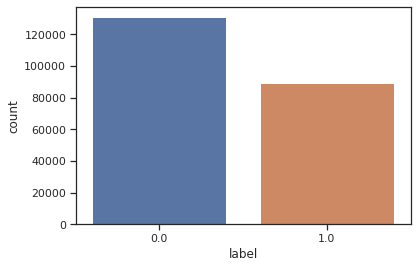

In [11]:
sns.countplot(x="label", data=df_training_classes)

So there are 130,908 negative(non-cancerous) samples and 89,117 positive(cancerous) samples. We need to rebalance the training dataset to remove this bias.



In [12]:
df_training_positive = df_training_classes[df_training_classes['label'] == 1] # +ve samples
df_training_negative = df_training_classes[df_training_classes['label'] == 0] # -ve samples
df_training_negative = df_training_negative.sample(n = df_training_positive.shape[0]) # shape[0] gives the number of rows

# Combine the positive and new negative samples into one DF, shuffle them and reset index.
df_training_balanced = pd.concat([df_training_positive, df_training_negative]).sample(frac = 1, random_state = 21488).reset_index(drop = True)
df_training_balanced.id = df_training_balanced.id + '.tif'
df_training_balanced.head(10)

,id,label
0,72c0159b3d3a581e30a7908d0784829896b839a2.tif,0.0
1,8106b1d808b1a3b1bd481ef63e08a521512fda54.tif,0.0
2,19909badc2fba7a729ece9729e0fdcb910db5434.tif,1.0
3,98efc03dcc353eb135affb3cbfb19c642cb76856.tif,1.0
4,0d2c97fb49efc9ce5c5494840615a141628fc383.tif,1.0
5,e161b1c00340f459214e99088a81206b1b800072.tif,0.0
6,dcacbf751a52681f8d946f7f9a3f663334e63a10.tif,0.0
7,10b8c23a81c06081a11e28b7049df3e199946ac7.tif,1.0
8,50f04e10190f15805b74f715481c098c9ebecdec.tif,1.0
9,5e8a117bd0b0358934a647be473c0dcf3114f53a.tif,0.0


<AxesSubplot:xlabel='label', ylabel='count'>

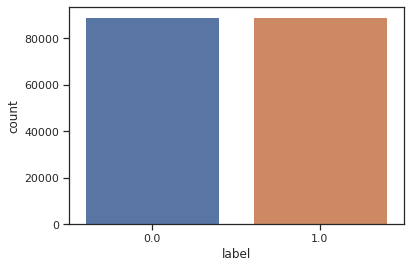

In [13]:
sns.countplot(x="label", data=df_training_balanced)

In [14]:
# Convert label back to string
df_training_balanced['label'] = df_training_balanced['label'].astype(str)
df_training_balanced.dtypes

id       object
label    object
dtype: object

We can see that the training dataset is now balanced. Let's checkout some of these images.

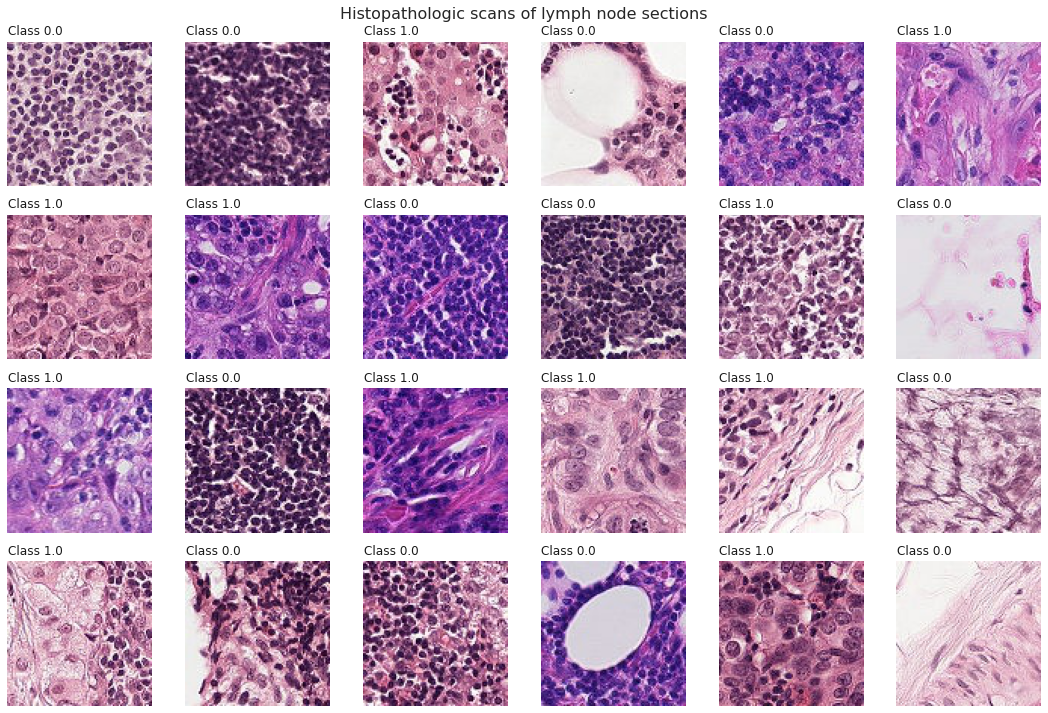

In [15]:
sample = df_training_balanced.sample(n=24).reset_index()
plt.figure(figsize=(15,15))
plt.suptitle('Histopathologic scans of lymph node sections',fontsize=16)
for i, row in sample.iterrows():
    img = imread(dir_train_images + f'{row.id}')    
    label = row.label

    plt.subplot(6,6,i+1)
    plt.imshow(img)
    plt.text(0, -5, f'Class {label}', color='k')        
    plt.axis('off')

plt.tight_layout()
plt.show()

Let's also verify the dimensions of an image:

In [16]:
imread(dir_train_images + f'{df_training_balanced.iloc[0].id}').shape 

(96, 96, 3)

#### Model Architecture

As I mentioned in the introduction, I am comparing VGG-16, EfficientNet, and a custom model similar to VGG-16 but using 12 Convolution layers instead.

Let's start with the VGG-16 model. VGG-16 is composed of 13 Convolution layers, 5 MaxPool layers, and 3 Fully Connected(Dense) layers. The structure is as follows:

1. **Input Layer**
2. **Convolution Layer 1**
    - Conv1.1 Layer with 64 filters
    - Conv1.2 Layer with 64 filters
    - MaxPool Layer
3. **Convolution Layer 2**
    - Conv2.1 Layer with 128 filters
    - Conv2.2 Layer with 128 filters
    - MaxPool Layer
4. **Convolution Layer 3**
    - Conv3.1 Layer with 256 filters
    - Conv3.2 Layer with 256 filters
    - Conv3.3 Layer with 256 filters
    - MaxPool Layer
5. **Convolution Layer 4**
    - Conv4.1 Layer with 512 filters
    - Conv4.2 Layer with 512 filters
    - Conv4.3 Layer with 512 filters
    - MaxPool Layer
6. **Convolution Layer 5**
    - Conv5.1 Layer with 512 filters
    - Conv5.2 Layer with 512 filters
    - Conv5.3 Layer with 512 filters    
    - MaxPool Layer
7. **Dense Layer 1**
8. **Dense Layer 2**
9. **Dense Layer 3**
10. **Output Layer**


The custom model is similar, it just changes the number of Convolution layers to 3 sets of 4.

Let's split the training dataset into a train and a validation subset.

In [17]:
df_training, df_validation = train_test_split(df_training_balanced, test_size=0.25, random_state=21488, stratify=df_training_balanced.label)

imgDataGen = ImageDataGenerator(rescale=1/255)

train_gen = imgDataGen.flow_from_dataframe(
    dataframe = df_training,
    directory = dir_train_images,
    x_col = 'id',
    y_col = 'label',
    batch_size = 64,
    seed = 21488,
    shuffle = True,
    class_mode = 'binary',
    target_size = (96,96))

valid_gen = imgDataGen.flow_from_dataframe(
    dataframe = df_validation,
    directory = dir_train_images,
    color_mode = 'rgb',
    x_col = 'id',
    y_col = 'label',
    batch_size = 64,
    seed = 21488,
    shuffle = True,
    class_mode = 'binary',
    target_size = (96,96))

Found 133675 validated image filenames belonging to 2 classes.
Found 44559 validated image filenames belonging to 2 classes.


In [18]:
train_steps = np.ceil(len(train_gen) / 64)
validation_steps = np.ceil(len(valid_gen) / 64)

print('train_steps: {}, validation_steps: {}'.format(train_steps, validation_steps))

train_steps: 33.0, validation_steps: 11.0


**VGG-16** was built to classify input into 1000 classes. Here we only have 2 classes, so we will use the base model and modify the output layer alone.

In [19]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (96, 96, 3), include_top = False, weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False
    
# Flatten the output layer to 1 dimension
op = keras.layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
op = keras.layers.Dense(512, activation='relu')(op)
op = keras.layers.Dropout(0.25)(op)

# Add a final sigmoid layer with 1 node for classification output
op = keras.layers.Dense(1, activation='sigmoid')(op)

model_vgg_16 = tf.keras.models.Model(base_model.input, op)

model_vgg_16.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'binary_crossentropy',metrics = ['accuracy', keras.metrics.AUC()])

model_vgg_16.summary()

2022-06-14 10:33:43.005233: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 10:33:43.107957: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 10:33:43.108754: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 10:33:43.109998: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
______________________________________________________________

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [20]:
start_time = time.time()
history_vgg_16 = model_vgg_16.fit(
    x = train_gen,
    steps_per_epoch = train_steps,
    validation_data = valid_gen,
    validation_steps = validation_steps,
    epochs = 30, # tried 15 epochs, accuracy wasn't that great for any of the models
    verbose = 1
)

print('Fitting the model took %.2f secs' % (time.time() - start_time))

2022-06-14 10:33:46.935894: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-06-14 10:33:49.092504: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


33/33 [==============================] - 26s 552ms/step - loss: 0.5349 - accuracy: 0.7263 - auc: 0.8058 - val_loss: 0.5081 - val_accuracy: 0.7401 - val_auc: 0.8648
Epoch 2/30
33/33 [==============================] - 18s 541ms/step - loss: 0.4698 - accuracy: 0.7827 - auc: 0.8579 - val_loss: 0.4192 - val_accuracy: 0.7898 - val_auc: 0.8948
Epoch 3/30
33/33 [==============================] - 17s 521ms/step - loss: 0.4521 - accuracy: 0.7822 - auc: 0.8693 - val_loss: 0.3978 - val_accuracy: 0.8168 - val_auc: 0.9016
Epoch 4/30
33/33 [==============================] - 18s 539ms/step - loss: 0.4478 - accuracy: 0.7869 - auc: 0.8726 - val_loss: 0.4134 - val_accuracy: 0.8125 - val_auc: 0.8913
Epoch 5/30
33/33 [==============================] - 16s 499ms/step - loss: 0.4258 - accuracy: 0.8134 - auc: 0.8863 - val_loss: 0.4108 - val_accuracy: 0.8097 - val_auc: 0.8959
Epoch 6/30
33/33 [==============================] - 16s 484ms/step - loss: 0.4457 - accuracy: 0.7945 - auc: 0.8750 - val_loss: 0.4155 - 

In [21]:
def plot_metrics(history_list, start=1):

    history = {}
    for k in history_list[0].history.keys():
        history[k] = sum([h.history[k] for h in history_list], [])
  
    epoch_range = range(start, len(history['loss']) +1)
    s = slice(start-1, None)
    n = int(len(history.keys()) / 2)
    
    plt.figure(figsize=[14,4])
    for i in range(n):
        k = list(history.keys())[i]
        plt.subplot(1, n, i+1)
        plt.plot(epoch_range, history[k][s], label='Training')
        plt.plot(epoch_range, history['val_' + k][s], label='Validation')
        plt.xlabel('Epoch'); plt.ylabel(k); plt.title(k)
        plt.grid()
        plt.legend()

    plt.tight_layout()
    plt.show()

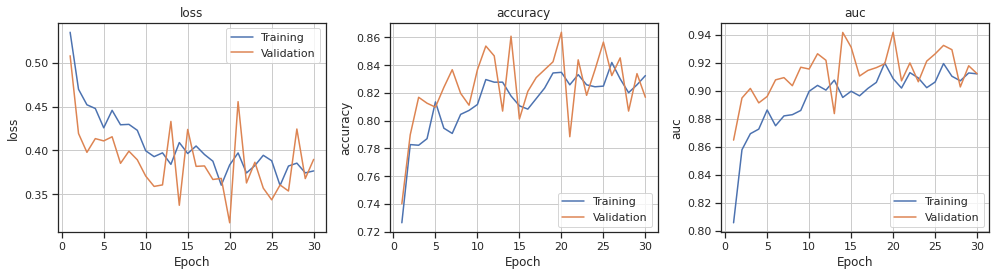

In [22]:
plot_metrics([history_vgg_16])

**EfficientNet** is the latest family of models from Google. Earlier models like ResNet follow the conventional approach of scaling dimensions arbitrarily and adding more layers. However, in EfficientNet we scale the dimensions by a fixed amount at the same time uniformly, thus achieving better performance. The scaling technique they use is called compound scaling.

Let's build the EfficientNet model now.

In [23]:
from tensorflow.keras.applications import EfficientNetB0

base_model_efn = EfficientNetB0(input_shape = (96, 96, 3), include_top = False, weights = 'imagenet')
for layer in base_model_efn.layers:
    layer.trainable = False

op_efn = base_model_efn.output
op_efn = Flatten()(op_efn)
op_efn = Dense(1024, activation="relu")(op_efn)
op_efn = Dropout(0.25)(op_efn)

# Add a final sigmoid layer with 1 node for classification output
predictions = Dense(1, activation="sigmoid")(op_efn)
model_efn = tf.keras.models.Model(base_model_efn.input, predictions)

model_efn.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001, decay=1e-6), loss = 'binary_crossentropy',metrics = ['accuracy', keras.metrics.AUC()])

model_efn.summary()

16719872/16705208 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 96, 96, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 96, 96, 3)    7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 97, 97, 3)    0           normalization[0][0]              
___________________________

In [24]:
start_time = time.time()
history_efn = model_efn.fit(
    x = train_gen,
    steps_per_epoch = train_steps,
    validation_data = valid_gen,
    validation_steps = validation_steps,
    epochs = 30, # tried 15 epochs, accuracy wasn't that great for any of the models
    verbose = 1
)

print('Fitting the model took %.2f secs' % (time.time() - start_time))

Epoch 1/30
33/33 [==============================] - 18s 383ms/step - loss: 1.1008 - accuracy: 0.5114 - auc_1: 0.5113 - val_loss: 0.8091 - val_accuracy: 0.4688 - val_auc_1: 0.5000
Epoch 2/30
33/33 [==============================] - 11s 343ms/step - loss: 0.8488 - accuracy: 0.5000 - auc_1: 0.4964 - val_loss: 0.7217 - val_accuracy: 0.5156 - val_auc_1: 0.4972
Epoch 3/30
33/33 [==============================] - 11s 329ms/step - loss: 0.8007 - accuracy: 0.4957 - auc_1: 0.5059 - val_loss: 0.7698 - val_accuracy: 0.4418 - val_auc_1: 0.5418
Epoch 4/30
33/33 [==============================] - 11s 325ms/step - loss: 0.7999 - accuracy: 0.4848 - auc_1: 0.4726 - val_loss: 0.7007 - val_accuracy: 0.4915 - val_auc_1: 0.5042
Epoch 5/30
33/33 [==============================] - 11s 325ms/step - loss: 0.7617 - accuracy: 0.4867 - auc_1: 0.4941 - val_loss: 0.7156 - val_accuracy: 0.5071 - val_auc_1: 0.5408
Epoch 6/30
33/33 [==============================] - 10s 315ms/step - loss: 0.7265 - accuracy: 0.5175 - au

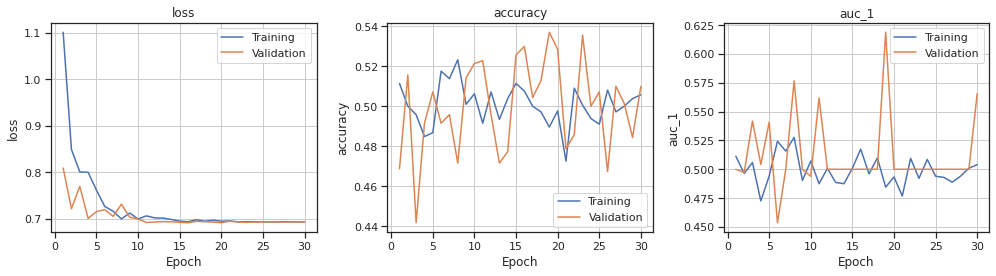

In [25]:
plot_metrics([history_efn])

The base EfficientNet B0 model seems to be performing poorly compared to VGG-16 on this dataset.

Next, let's try the custom model.

In [26]:
# Consists of 3 sets of 4 convolution layers
model_custom = Sequential()
model_custom.add(Conv2D(32, (3, 3), padding='same',input_shape=(96,96,3)))
model_custom.add(Activation('relu'))
model_custom.add(Conv2D(32, (3, 3)))
model_custom.add(Activation('relu'))
model_custom.add(Conv2D(32, (3, 3)))
model_custom.add(Activation('relu'))
model_custom.add(Conv2D(32, (3, 3)))
model_custom.add(Activation('relu'))
model_custom.add(MaxPooling2D(pool_size=(2, 2)))
model_custom.add(BatchNormalization())

model_custom.add(Conv2D(64, (3, 3)))
model_custom.add(Activation('relu'))
model_custom.add(Conv2D(64, (3, 3)))
model_custom.add(Activation('relu'))
model_custom.add(Conv2D(64, (3, 3)))
model_custom.add(Activation('relu'))
model_custom.add(Conv2D(64, (3, 3)))
model_custom.add(Activation('relu'))
model_custom.add(MaxPooling2D(pool_size=(2, 2)))
model_custom.add(BatchNormalization())

model_custom.add(Conv2D(128, (3, 3)))
model_custom.add(Activation('relu'))
model_custom.add(Conv2D(128, (3, 3)))
model_custom.add(Activation('relu'))
model_custom.add(Conv2D(128, (3, 3)))
model_custom.add(Activation('relu'))
model_custom.add(Conv2D(128, (3, 3)))
model_custom.add(Activation('relu'))
model_custom.add(MaxPooling2D(pool_size=(2, 2)))
model_custom.add(BatchNormalization())
          
model_custom.add(Flatten())
model_custom.add(Dropout(0.25))
model_custom.add(Dense(512))
model_custom.add(Activation('relu'))

model_custom.add(Dropout(0.25))
model_custom.add(Dense(256))
model_custom.add(Activation('relu'))

model_custom.add(Dropout(0.25))
model_custom.add(Dense(64))
model_custom.add(Activation('relu')) 

model_custom.add(Dropout(0.25))
model_custom.add(Dense(1, activation='sigmoid'))
model_custom.compile(optimizer = tf.keras.optimizers.RMSprop(0.0001), loss = 'binary_crossentropy',metrics = ['accuracy', keras.metrics.AUC()])

model_custom.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 94, 94, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 94, 94, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 92, 92, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 92, 92, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 90, 90, 32)        9

In [27]:
start_time = time.time()
history_custom = model_custom.fit(
    x = train_gen,
    steps_per_epoch = train_steps,
    validation_data = valid_gen,
    validation_steps = validation_steps,
    epochs = 30, # tried 15 epochs, accuracy wasn't that great for any of the models
    verbose = 1
)

print('Fitting the model took %.2f secs' % (time.time() - start_time))

Epoch 1/30
33/33 [==============================] - 11s 260ms/step - loss: 0.6372 - accuracy: 0.6728 - auc_2: 0.7384 - val_loss: 0.7158 - val_accuracy: 0.4957 - val_auc_2: 0.4895
Epoch 2/30
33/33 [==============================] - 8s 249ms/step - loss: 0.5809 - accuracy: 0.7372 - auc_2: 0.7928 - val_loss: 0.7815 - val_accuracy: 0.4759 - val_auc_2: 0.5386
Epoch 3/30
33/33 [==============================] - 8s 257ms/step - loss: 0.5381 - accuracy: 0.7448 - auc_2: 0.8208 - val_loss: 0.8213 - val_accuracy: 0.5284 - val_auc_2: 0.5525
Epoch 4/30
33/33 [==============================] - 8s 244ms/step - loss: 0.5376 - accuracy: 0.7552 - auc_2: 0.8176 - val_loss: 0.9016 - val_accuracy: 0.5185 - val_auc_2: 0.5777
Epoch 5/30
33/33 [==============================] - 8s 240ms/step - loss: 0.5563 - accuracy: 0.7434 - auc_2: 0.8049 - val_loss: 1.0544 - val_accuracy: 0.4858 - val_auc_2: 0.5828
Epoch 6/30
33/33 [==============================] - 8s 245ms/step - loss: 0.5223 - accuracy: 0.7495 - auc_2: 

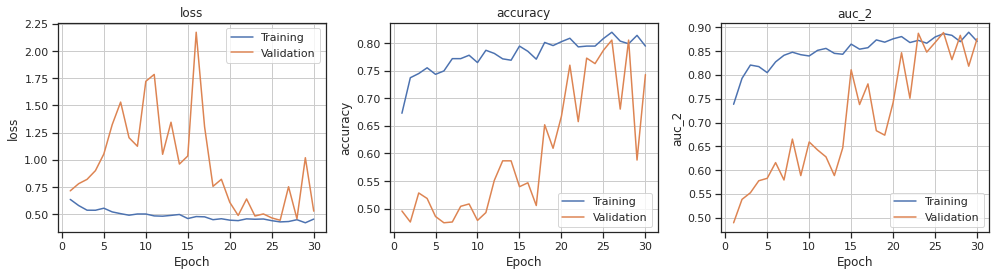

In [28]:
plot_metrics([history_custom])

Based on these plots, I think VGG-16 is the way to go.
I'm going to try VGG-16 with the Adam optimizer instead, which is supposed to perform better than the RMSProp optimizer.

In [29]:
model_vgg_16.compile(optimizer = tf.keras.optimizers.Adam(0.0001), loss = 'binary_crossentropy',metrics = ['accuracy', keras.metrics.AUC()])
model_vgg_16.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0     

In [30]:
start_time = time.time()
history_vgg_16_adam = model_vgg_16.fit(
    x = train_gen,
    steps_per_epoch = train_steps,
    validation_data = valid_gen,
    validation_steps = validation_steps,
    epochs = 30, # tried 15 epochs, accuracy wasn't that great for any of the models
    verbose = 1
)

print('Fitting the model took %.2f secs' % (time.time() - start_time))

Epoch 1/30
33/33 [==============================] - 8s 215ms/step - loss: 0.3646 - accuracy: 0.8395 - auc_3: 0.9178 - val_loss: 0.3362 - val_accuracy: 0.8423 - val_auc_3: 0.9335
Epoch 2/30
33/33 [==============================] - 7s 204ms/step - loss: 0.3728 - accuracy: 0.8329 - auc_3: 0.9140 - val_loss: 0.3700 - val_accuracy: 0.8281 - val_auc_3: 0.9265
Epoch 3/30
33/33 [==============================] - 7s 204ms/step - loss: 0.3816 - accuracy: 0.8224 - auc_3: 0.9084 - val_loss: 0.3769 - val_accuracy: 0.8239 - val_auc_3: 0.9153
Epoch 4/30
33/33 [==============================] - 7s 203ms/step - loss: 0.3645 - accuracy: 0.8433 - auc_3: 0.9187 - val_loss: 0.3789 - val_accuracy: 0.8310 - val_auc_3: 0.9145
Epoch 5/30
33/33 [==============================] - 7s 210ms/step - loss: 0.3542 - accuracy: 0.8300 - auc_3: 0.9219 - val_loss: 0.3731 - val_accuracy: 0.8438 - val_auc_3: 0.9157
Epoch 6/30
33/33 [==============================] - 7s 201ms/step - loss: 0.3503 - accuracy: 0.8447 - auc_3: 0

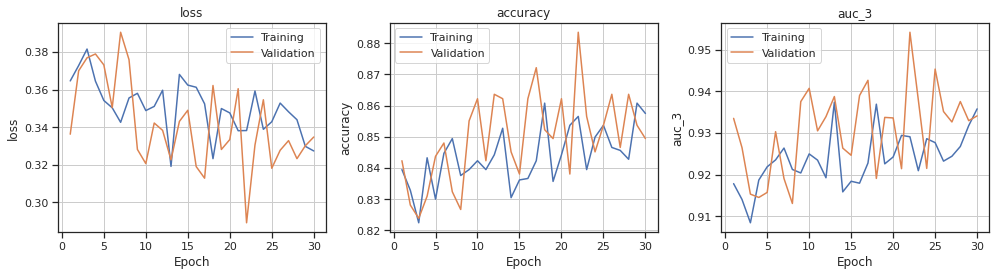

In [31]:
plot_metrics([history_vgg_16_adam])

Comparing the accuracy and loss graphs of VGG-16 with RMSProp against Adam optimizer, it is clearly seen that Adam performs better.
Also, I tried training all the models with 15 epochs, but the accuracy was not great, so I increased the number of epochs to 30.

In [32]:
df_testing = pd.DataFrame(os.listdir(dir_test_images))
df_testing.columns = ['id']
df_testing.head()

,id
0,a7ea26360815d8492433b14cd8318607bcf99d9e.tif
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0.tif
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62.tif


In [33]:
test_datagen = ImageDataGenerator(rescale=1/255)

testing_generator = test_datagen.flow_from_dataframe(
    dataframe = df_testing,
    directory = dir_test_images,
    x_col = "id",
    batch_size = 64,
    seed = 21488,
    shuffle = False,
    class_mode = None,
    target_size = (96,96)
)

Found 57458 validated image filenames.


In [37]:
predictions_test = model_vgg_16.predict(testing_generator, steps = testing_generator.n / 2, verbose = 1)


28729/28729 [==============================] - 215s 7ms/step


NameError: name 'preds' is not defined

In [40]:
predictions = []

for pred in predictions_test:
    predictions.append(1) if pred >= 0.5 else predictions.append(0)
    
predictions[:10]

predictions_test.shape

(57458, 1)

In [41]:
submission = df_testing.copy()
submission['id'] = submission['id'].str[:-4] # Removing the ".tif" suffix from the id
submission['label'] = predictions
submission.head()

,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,1
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,1
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,1
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,0


In [42]:
submission.to_csv('submission.csv',index=False)